#Import

In [12]:
import keras
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

#load dataset and Shuffle

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = shuffle(x_train, y_train)

In [3]:
print("shape of x_train:", x_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of x_test:", x_test.shape)
print("shape of y_test:", y_test.shape)

shape of x_train: (60000, 28, 28)
shape of y_train: (60000,)
shape of x_test: (10000, 28, 28)
shape of y_test: (10000,)


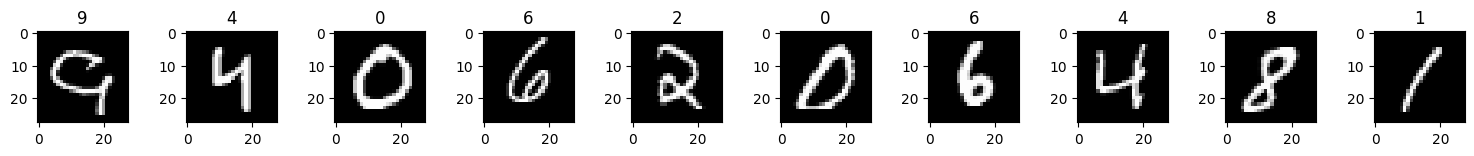

In [4]:
fig, axs = plt.subplots(1, 10, figsize=(15, 5))
fig.tight_layout()
for i in range(10):
    axs[i].imshow(x_train[i], cmap='gray')
    axs[i].set_title(y_train[i])

#Reshaping

In [5]:
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

x_train = x_train/255.0
x_test = x_test/255.0

print("shape of x_train:",x_train.shape)
print("shape of x_test:",x_test.shape)

shape of x_train: (60000, 28, 28, 1)
shape of x_test: (10000, 28, 28, 1)


In [6]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("shape of y_train:", y_train.shape)
print("shape of y_test:", y_test.shape)

shape of y_train: (60000, 10)
shape of y_test: (10000, 10)


#Implement the Model

In [9]:
model = Sequential([
            Conv2D(32, (3,3), padding='same', activation='relu'),
            MaxPool2D(pool_size=(2, 2)),
            Conv2D(64, (3,3), padding='same', activation='relu'),
            MaxPool2D(pool_size=(2, 2)),
            Conv2D(128, (3,3), padding='same', activation='relu'),
            MaxPool2D(pool_size=(2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dense(10, activation='softmax')
])

In [10]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [11]:
history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/15
938/938 [==============================] - 17s 6ms/step - loss: 0.1606 - accuracy: 0.9506 - val_loss: 0.0352 - val_accuracy: 0.9892
Epoch 2/15
938/938 [==============================] - 5s 6ms/step - loss: 0.0413 - accuracy: 0.9872 - val_loss: 0.0371 - val_accuracy: 0.9876
Epoch 3/15
938/938 [==============================] - 4s 5ms/step - loss: 0.0292 - accuracy: 0.9909 - val_loss: 0.0240 - val_accuracy: 0.9918
Epoch 4/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0232 - accuracy: 0.9921 - val_loss: 0.0237 - val_accuracy: 0.9925
Epoch 5/15
938/938 [==============================] - 5s 6ms/step - loss: 0.0182 - accuracy: 0.9938 - val_loss: 0.0220 - val_accuracy: 0.9925
Epoch 6/15
938/938 [==============================] - 4s 5ms/step - loss: 0.0139 - accuracy: 0.9955 - val_loss: 0.0325 - val_accuracy: 0.9898
Epoch 7/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0136 - accuracy: 0.9956 - val_loss: 0.0288 - val_accuracy: 0.9911
Epoch

#GRAD-CAM algorithm

In [24]:
def render_images(images):
  columns = int(len(images)/3)
  rows = 3
  fig = plt.figure(figsize=(rows*14, columns))
  for i in range(0, 30, 3):
    fig.add_subplot(rows, columns, int(i/3) + 1)
    plt.imshow(images[i])
  for i in range(1, 30, 3):
    fig.add_subplot(rows, columns, 10 + int((i-1)/3)+1)
    plt.imshow(images[i])
  for i in range(2, 30, 3):
    fig.add_subplot(rows, columns, 20 + int((i-2)/3)+1)
    plt.imshow(images[i])

  fig.tight_layout()
  plt.show()

In [25]:
def grad_cam(image, layer_name):
  gradModel = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])


  img_array = np.expand_dims(image, axis=0)
  with tf.GradientTape() as tape:
    (convOutputs, predictions) = gradModel(img_array)
    loss = predictions[:, 0]

  grads = tape.gradient(loss, convOutputs)
  castConvOutputs = tf.cast(convOutputs > 0, "float32")
  castGrads = tf.cast(grads > 0, "float32")
  guidedGrads = castConvOutputs * castGrads * grads

  weights = tf.reduce_mean(guidedGrads[0], axis=(0, 1))
  cam = tf.reduce_sum(tf.multiply(weights, convOutputs[0]), axis=-1)

  heatmap = cv2.resize(cam.numpy(), (img_array.shape[2], img_array.shape[1]))
  heatmap = (heatmap - np.min(heatmap)) / ((heatmap.max() - heatmap.min()) + 1e-25)

  return heatmap

In [26]:
def superimpose(image, heatmap):
  heatmap = cv2.resize(heatmap, (28, 28))
  heatmap = cv2.cvtColor(np.uint8(255 * heatmap), cv2.COLOR_GRAY2RGB)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = np.minimum(heatmap * 0.5+ image, 255.0).astype(np.uint8)
  superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

  return superimposed_img_rgb

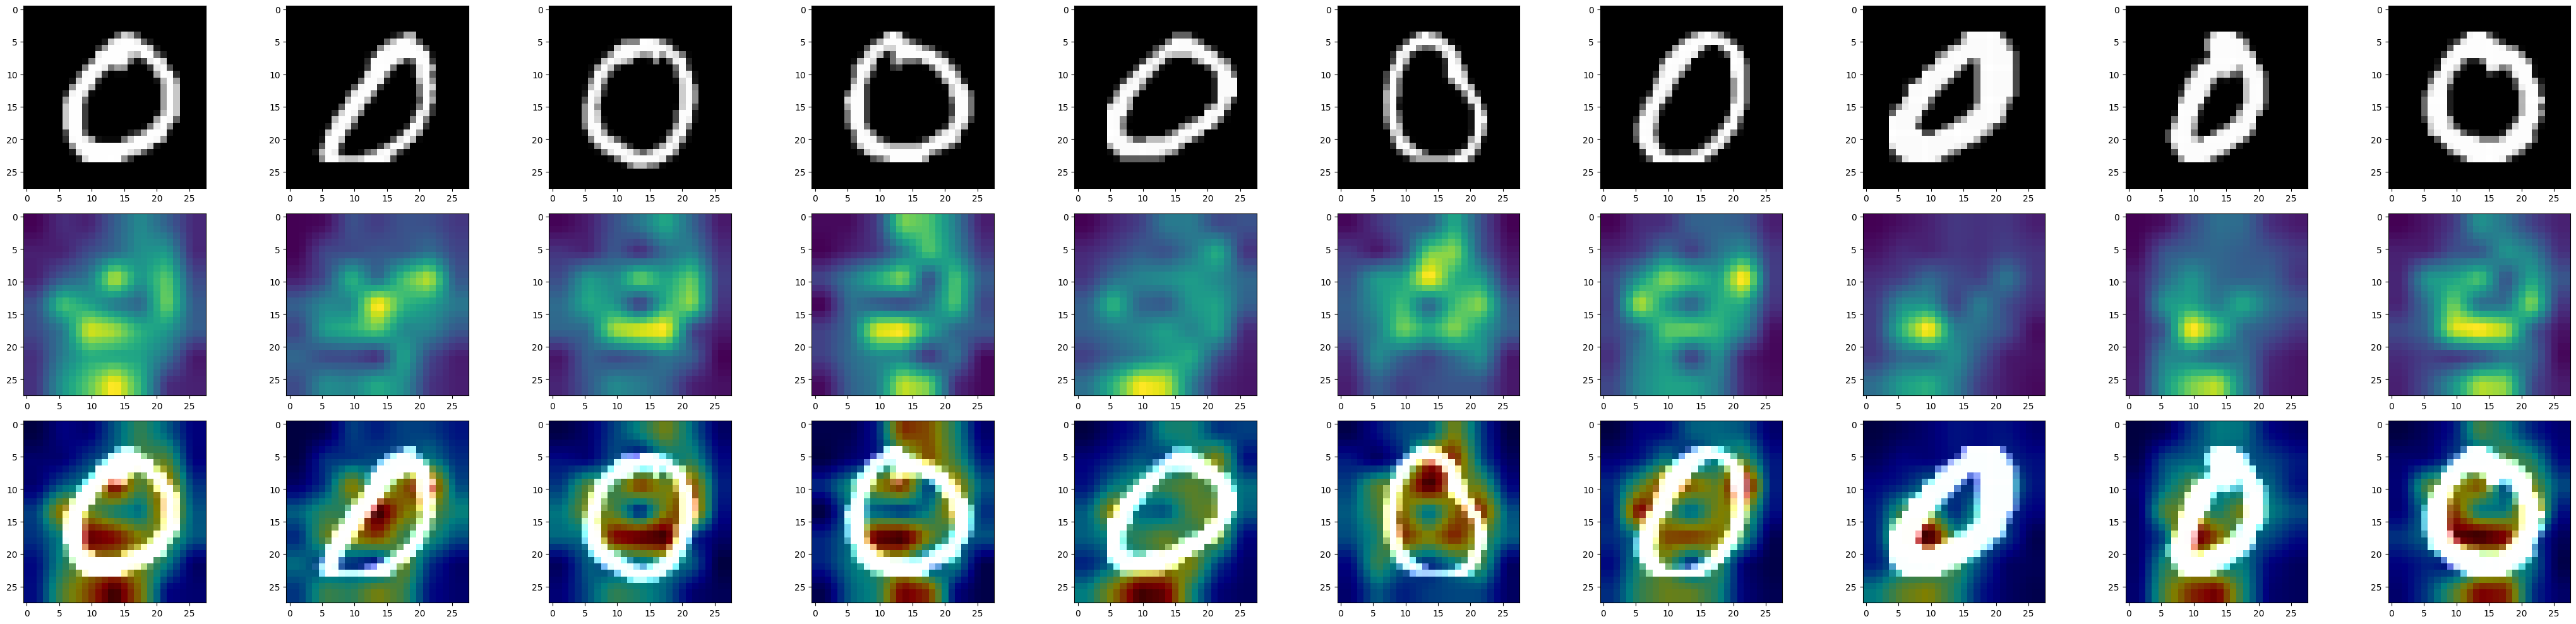

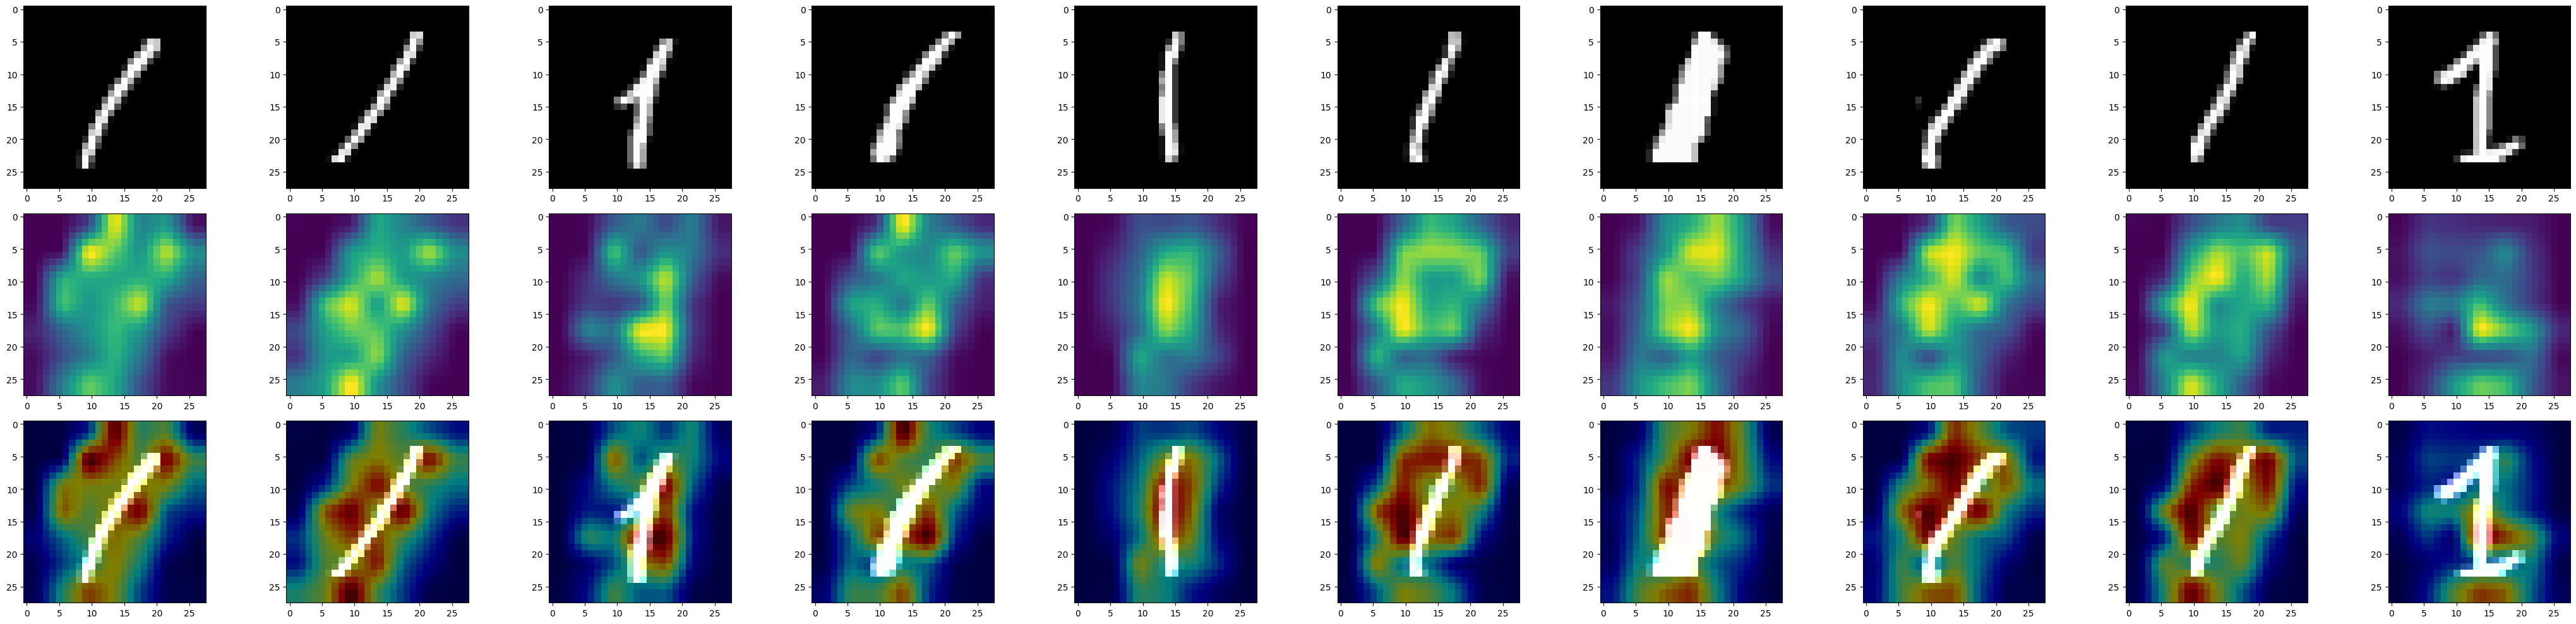

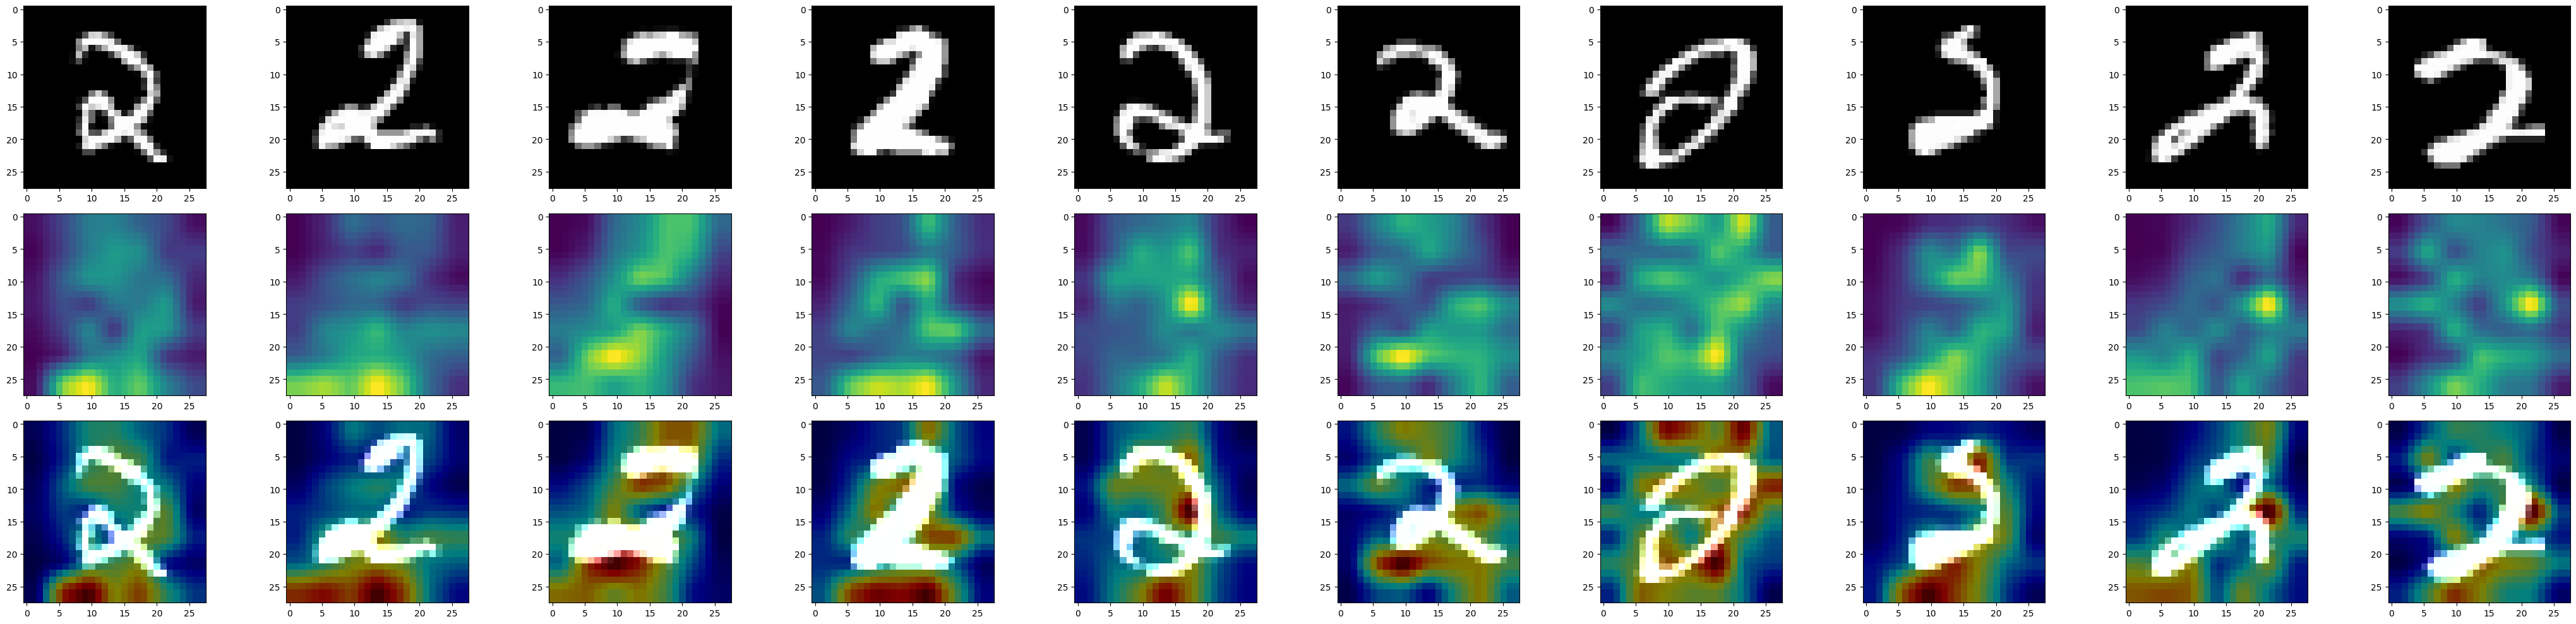

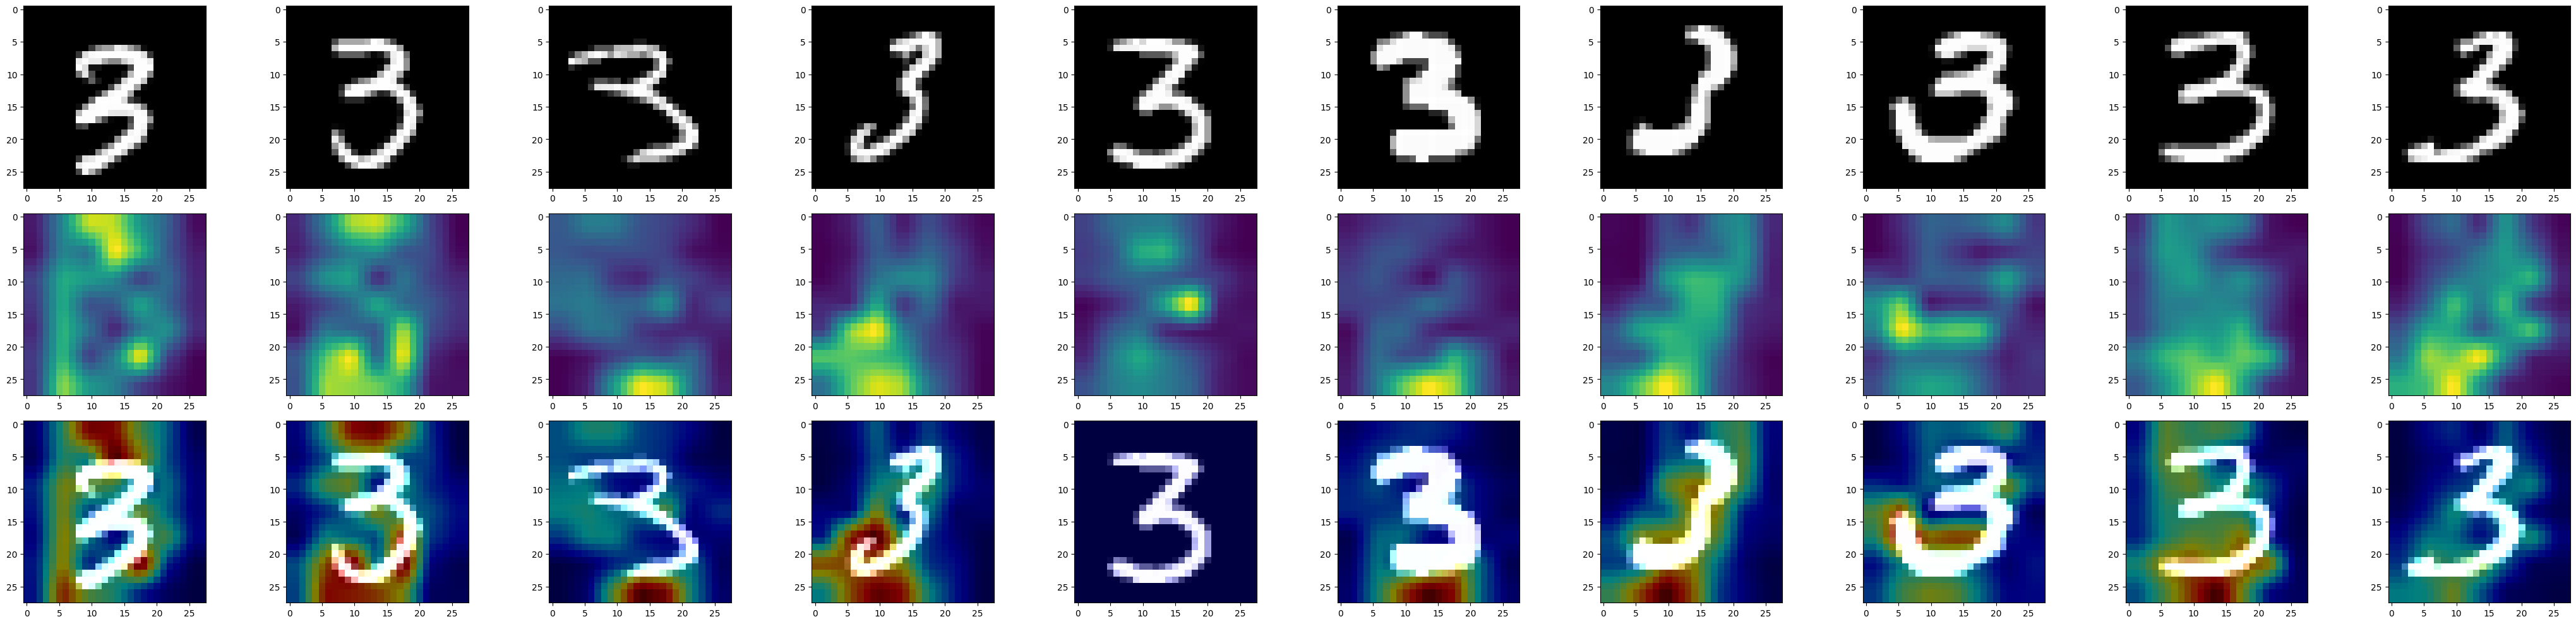

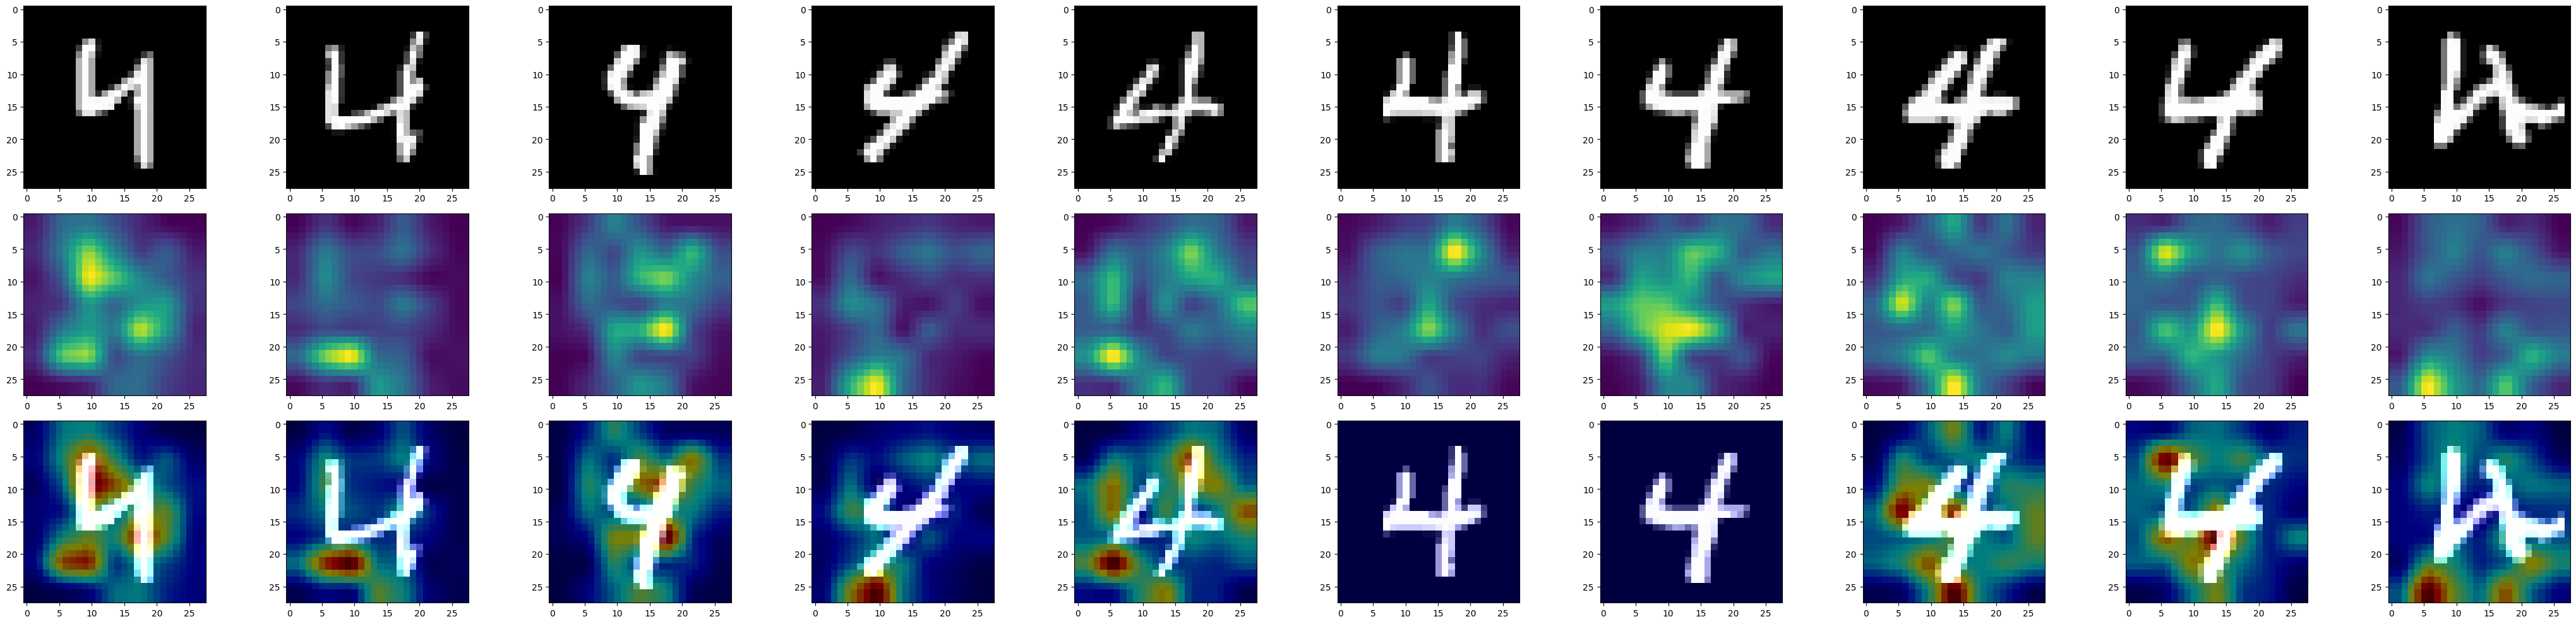

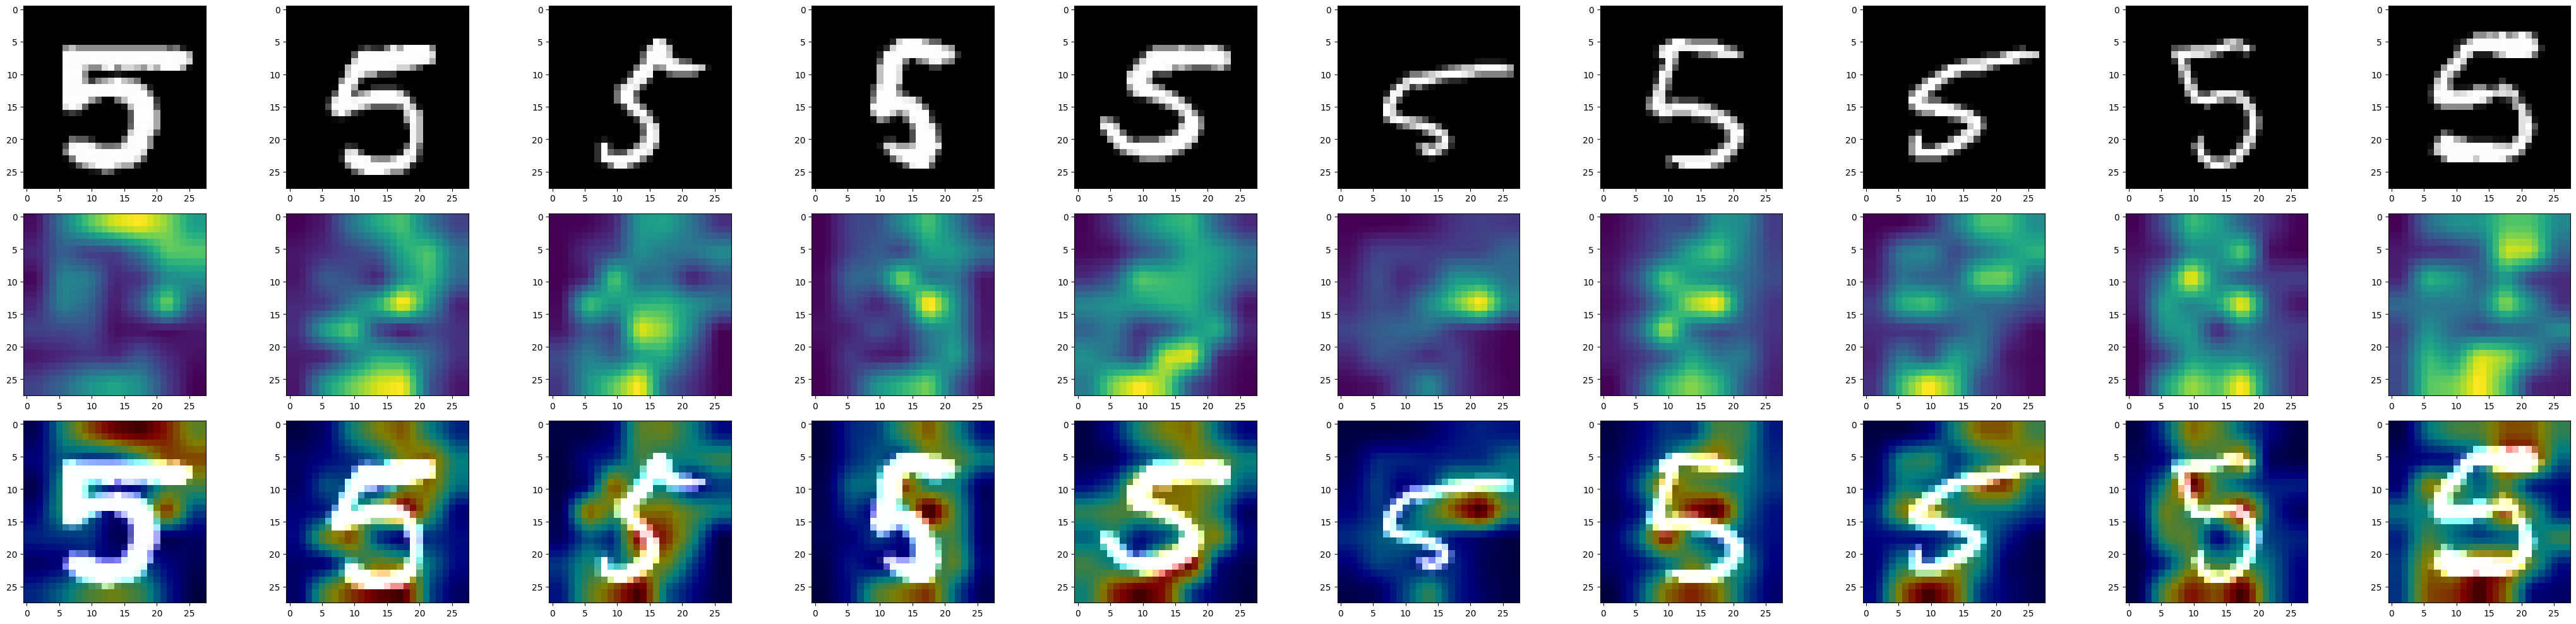

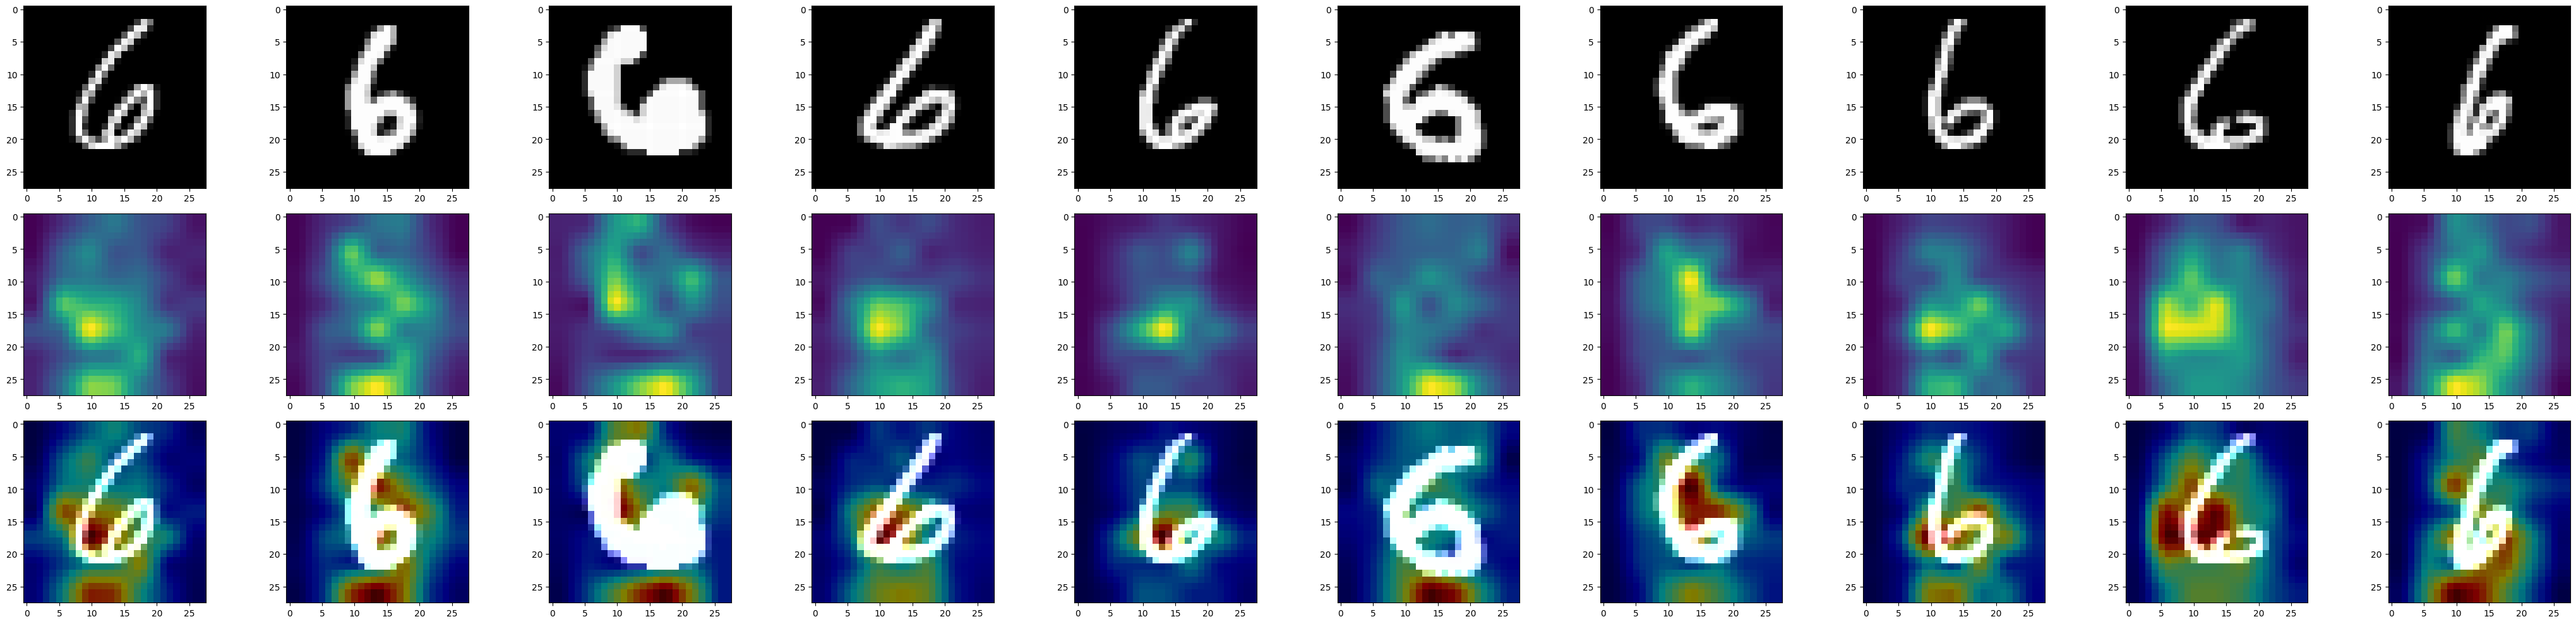

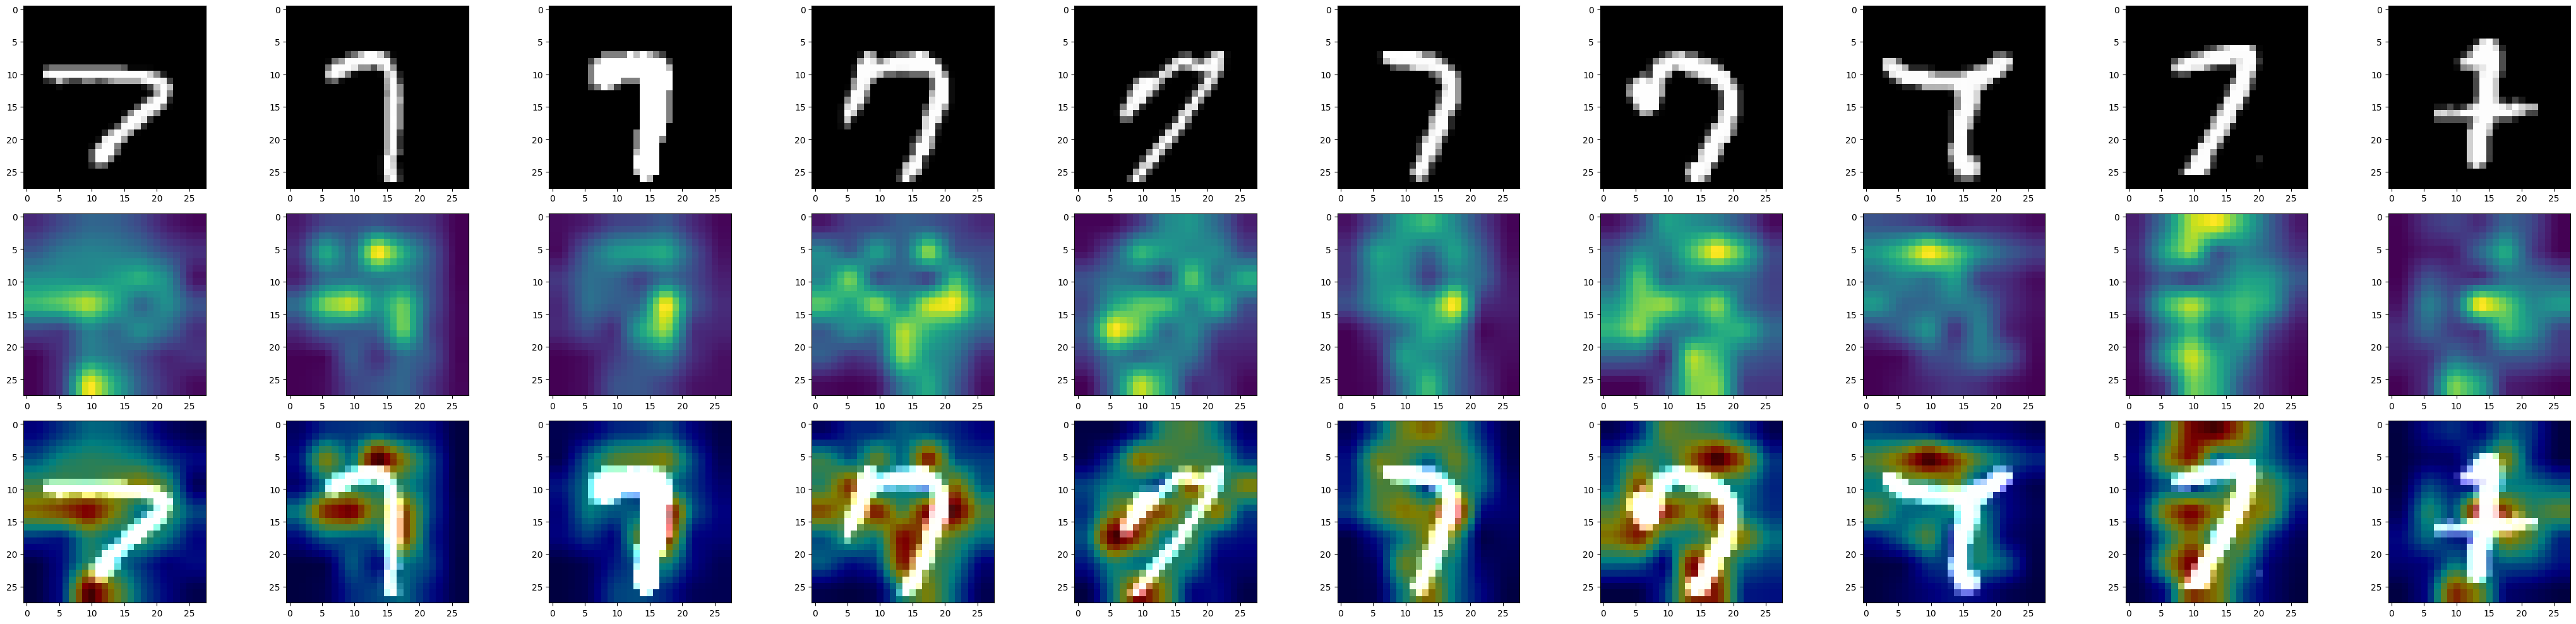

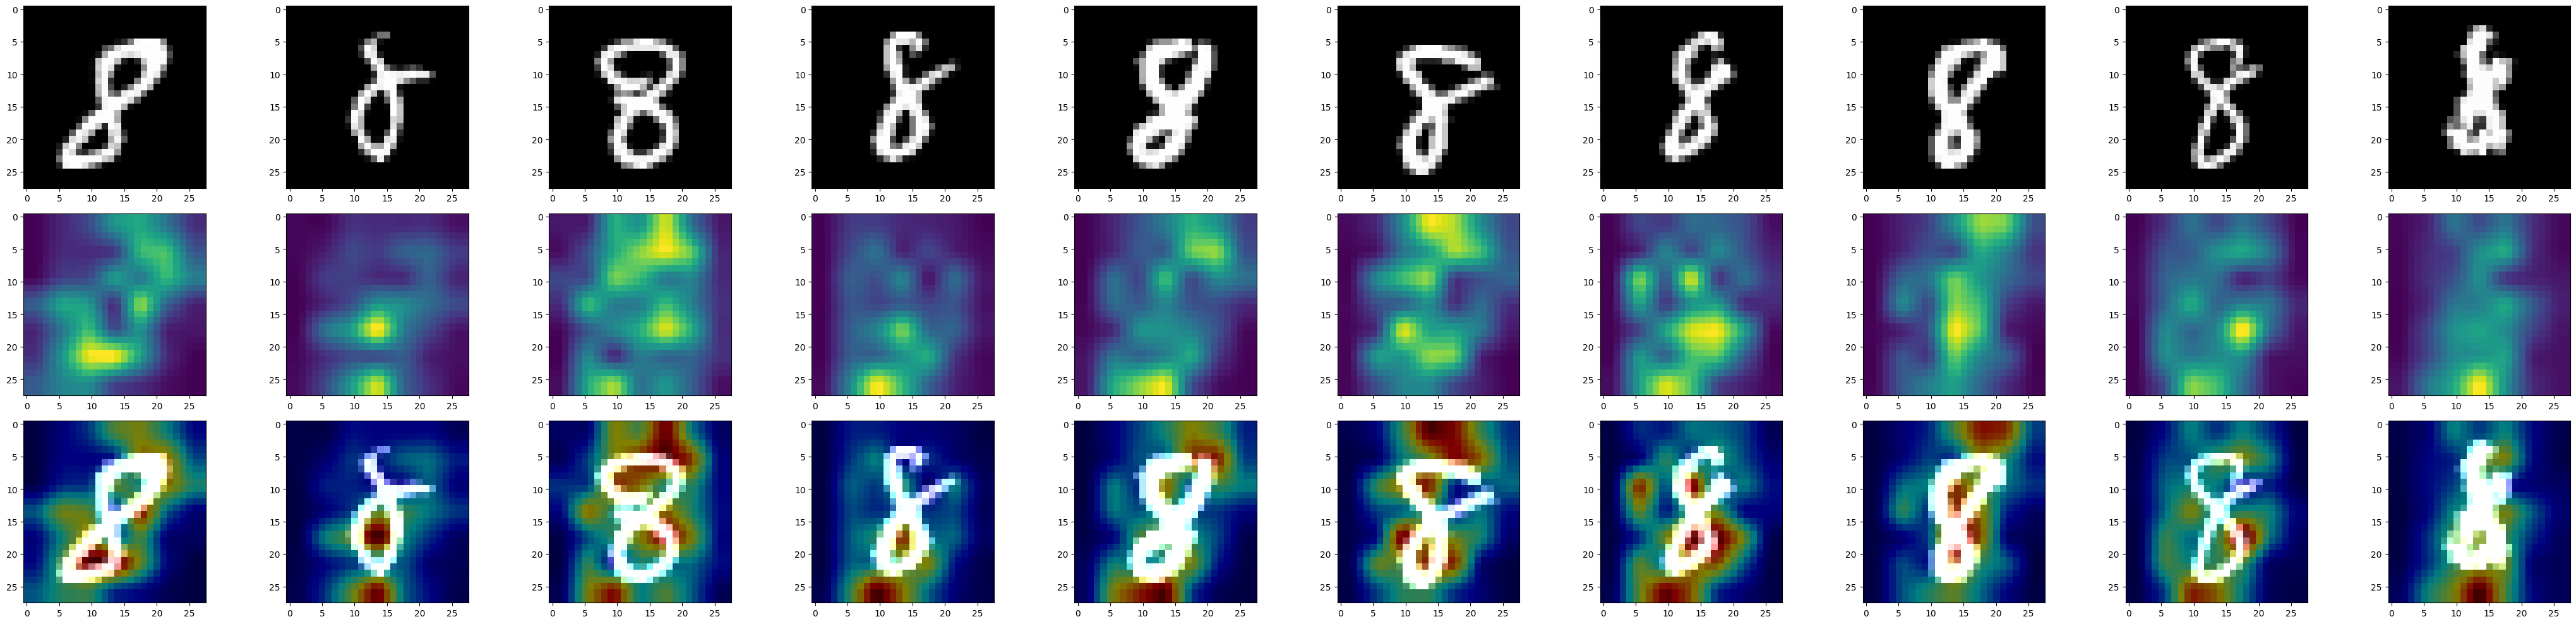

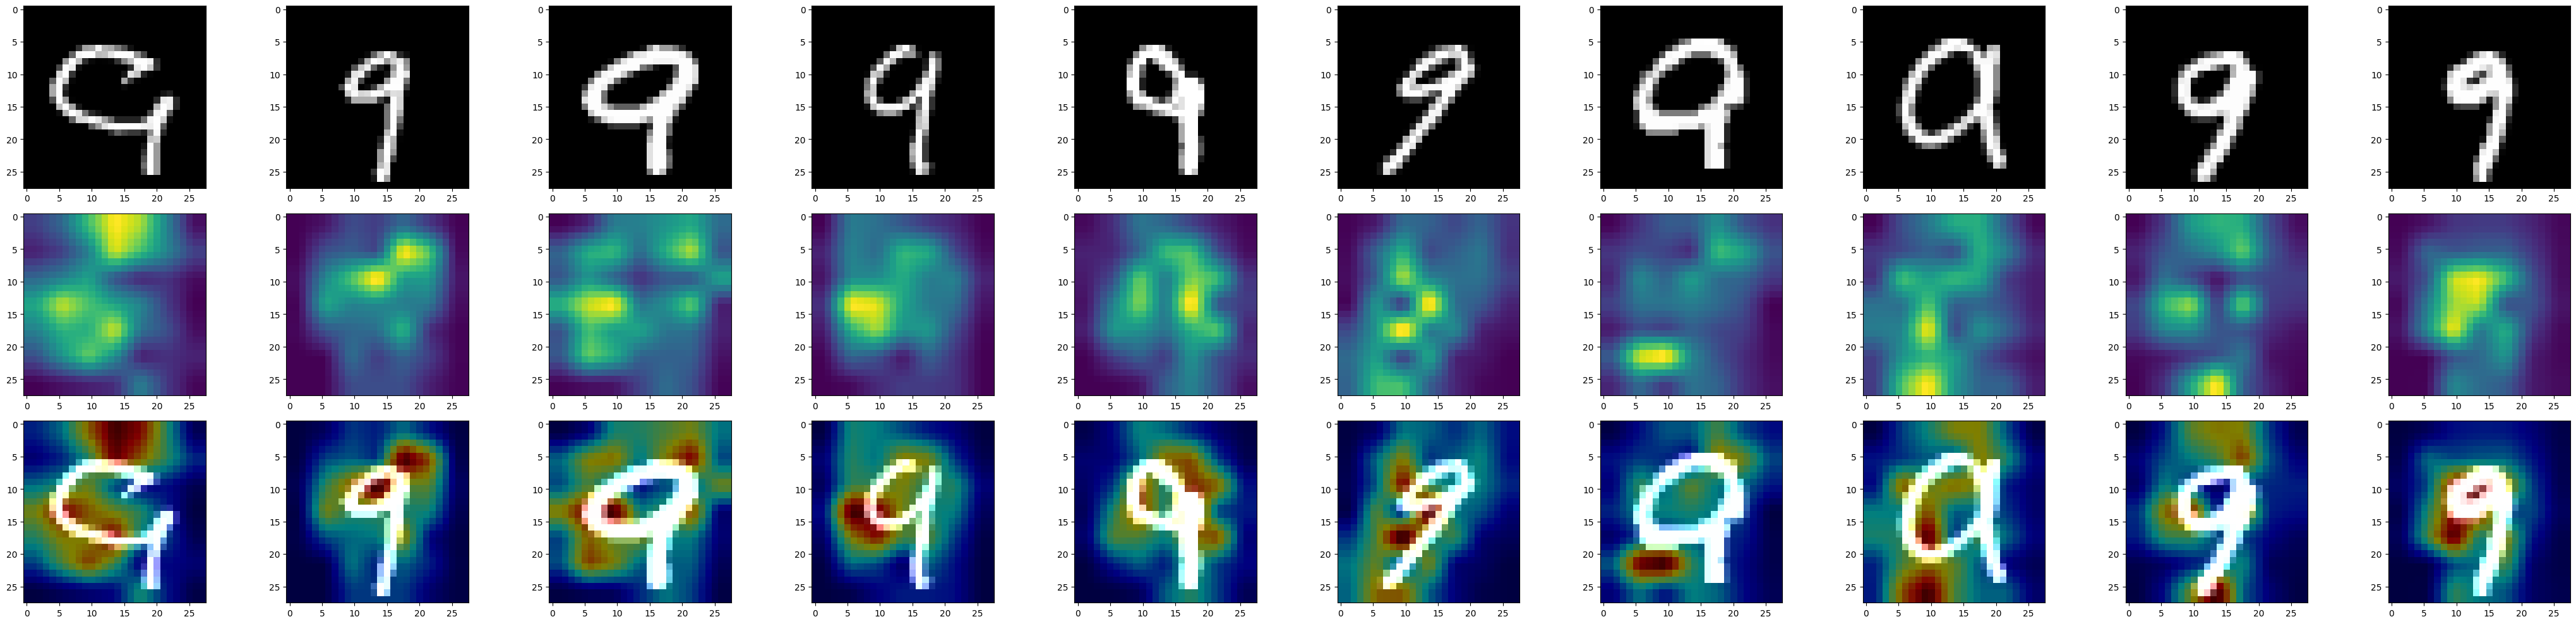

In [29]:
for i in range(10):
  images = []
  c = 0
  while len(images) < 30:
    if y_train[c, i] == 1:
      image = x_train[c]

      temp = cv2.cvtColor(np.uint8(255 * image), cv2.COLOR_GRAY2RGB)
      images.append(temp)

      heatmap = grad_cam(image, 'conv2d_2')
      images.append(heatmap)

      superimposed = superimpose(temp, heatmap)
      images.append(superimposed)
    c+=1

  render_images(images)

  print('\n')